In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from copy import deepcopy

In [2]:
dataset = pd.read_csv('series/multivariate-time-series-data-master/traffic/traffic.txt',header=None)

In [3]:
data = dataset[dataset.shape[0]-2000:dataset.shape[0]-24*9]

In [4]:
data1 = data.values

In [5]:
#data = data1[:,[0, 61, 147, 241]]
data = data1[:,:4]

In [6]:
data.shape

(1784, 4)

In [7]:

#Basic informations 

num_predictors = 70
num_input = 15
lag = 24*3
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False
h_prev = 24
#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

#bin_values = 12; #Representação da binarização do tempo.
num_series = data.shape[1]  #Numero de series do problema, extraído dos dados

max_rulesize = 4 #Max numbers of premises rules.
min_activation = 0.72 #Minimum activation

#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
num_groups = 9

ensemble_rules = None

total_number = data.shape[1]*lag

In [8]:
import seaborn as sns
from copy import deepcopy
from utils import *

import itertools
import json
import os

#For e-autoMFIS, we import all of them.
from autoMFIS import *
import numpy as np
import scipy.io
from reweight import Reweight
from fuzzyfication import Fuzzification
from defuzzification import Defuzzification
import matplotlib.pyplot as plt
from predict import predict



def convert_object_to_float(data,datanames):
    
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

##Assertion for ensemble rules
#Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

#This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
def correct_bug(ensemble_rules,max_rulesize=0):
    correct_rule = []
    d_stacked_rules = []
    new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


    for  n_times in range(ensemble_rules.shape[1]):
        t_rules = ensemble_rules[:,n_times]
        correct_rule = []
        d_stacked_rules = []
        k = 0
        for rule in t_rules:
            #print(rule)
            #print(len(rule))
            #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
            if len(rule) > max_rulesize + 1:
                #print(rule)
                for i in rule:
                    #k += 1
                    if isinstance(i,tuple):
                        #print(i)
                        correct_rule.append(i)
                    else:
                        if len(correct_rule) == 0:
                            #print(i)
                            pass
                            #d_stacked_rules.append(i)
                        else:
                            #print(correct_rule)
                            new_ensemble_rules[k,n_times] = correct_rule
                            k += 1
                            #d_stacked_rules.append(correct_rule)
                            correct_rule = []
                            #d_stacked_rules.append(i)
            else:
                new_ensemble_rules[k,n_times] = rule
                k += 1
                #d_stacked_rules.append(rule)
            
        #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

    return new_ensemble_rules

def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
    t_rules = deepcopy(new_ensemble_rules[:,0])
    no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
    no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
    no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
    new_t_rules = None

    k = 0
    j = 0
    for rule in t_rules:
        if new_t_rules is None:
            new_t_rules = [rule]
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1

        elif not check_duplicate_rules(rule,new_t_rules):
            new_t_rules.append(rule)
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1
        j += 1

    new_rules = deepcopy(no_duplicated_ensemble[:k,:])
    new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
    new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

    return new_rules, new_prem_terms, new_antecedents



In [9]:
'''
if diff_series:
    diff_data = data[1:,:] - data[0:data.shape[0]-1,:]

    in_sample = diff_data[:diff_data.shape[0]-h_prev,:]
    
    out_sample = diff_data[diff_data.shape[0]-h_prev:,:]

elif detrend_series:
    detrended = np.zeros((data.shape))
    trends = np.zeros((data.shape))

    for i in range(data.shape[1]):
        x_detrend = [k for k in range(0, data.shape[0])]
        x_detrend = np.reshape(x_detrend, (len(x_detrend), 1))
        y = data[:,i]
        model = LinearRegression()
        model.fit(x_detrend, y)
        # calculate trend
        trend = model.predict(x_detrend)
        trends[:,i] = [trend[k1] for k1 in range(0,len(x_detrend))]
        # plot trend
        plt.plot(y)
        plt.plot(trend)
        plt.show()
        # detrend
        detrended[:,i] = [y[k2]-trend[k2] for k2 in range(0, len(x_detrend))]
        
    in_sample = detrended[:detrended.shape[0]-h_prev,:]
    out_sample = detrended[detrended.shape[0]-h_prev:,:]
    
else:
    in_sample = data[:data.shape[0]-h_prev,:]
    out_sample = data[data.shape[0]-h_prev:,:]


#Definicao do target
yt = np.zeros((in_sample.shape[0]-lag-1,num_series),dtype='float')

#Todas as entradas defasadas 
yp = np.zeros((in_sample.shape[0]-lag-1,num_series), dtype='float')
yp_lagged = np.zeros((in_sample.shape[0]-lag-1,num_series*lag),dtype='float')

for i in range(num_series):
    yp[:,i] = in_sample[lag:in_sample.shape[0]-1,i]
    yt[:,i] = in_sample[lag+1:,i]
    for k in range(lag):
        yp_lagged[:,i*lag+k] = in_sample[lag-k:in_sample.shape[0]-k-1,i]
        #print(i*lag+k)
'''
#Definicao do target
yt = np.zeros((data.shape[0]-h_prev-lag-1,num_series),dtype='float')

#Todas as entradas defasadas 
yp = np.zeros((data.shape[0]-h_prev-lag-1,num_series), dtype='float')
yp_lagged = np.zeros((data.shape[0]-h_prev-lag-1,num_series*lag),dtype='float')

for i in range(num_series):
    yp[:,i] = data[lag:data.shape[0]- h_prev - 1,i]
    yt[:,i] = data[lag+1:data.shape[0]- h_prev,i]
    for k in range(lag):
        yp_lagged[:,i*lag+k] = data[lag-k:data.shape[0]- h_prev - k-1,i]
        #print(i*lag+k)





In [10]:
t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]

In [11]:
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

In [12]:
yp = deepcopy(yp[t_lagged,:])
yt = deepcopy(yt[t_lagged,:])
yp_lagged = deepcopy(yp_lagged[t_lagged,:])

data = deepcopy(data[t[len(t)-len(t_lagged):],:])
in_sample = data[:data.shape[0]-h_prev,:]
out_sample = data[data.shape[0]-h_prev:,:]

In [13]:
len(t_lagged)

216

In [14]:
in_sample[1]

array([0.0456, 0.038 , 0.0875, 0.0525])

In [15]:
yt[0]

array([0.0456, 0.038 , 0.0875, 0.0525])

In [ ]:
###############Fuzzificacao

Fuzzyfy = Fuzzification(fuzzy_method)

#Lembrete: 
#axis 0 - Registros da série
#axis 1 - Valor de pertinência ao conjunto Fuzzy
#axis 2 - Numero de séries

first_time = True
for n in range(num_series):
    
    _, mf_params = Fuzzyfy.fuzzify(in_sample[:,n],np.array([]),num_groups=num_groups)
    mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
    mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
    if first_time:
        mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
        mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
        mf_params_ = np.ndarray([mf_params.shape[0],num_series])
        first_time = False
    mX_[:,:,n] = mX
    mY_[:,:,n] = mY
    mf_params_[:,n] = mf_params.ravel()
    #print(mf_params)
    #print(mX.shape)


mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
for i in range(num_series):
    mf_params = mf_params_[:,i]
    for j in range(lag):
        mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
        mX_lagged_[:,:,i*lag+j] = mX
        #print(i*lag+j)


#mX_lagged_[:,:,not_select_subsample] = 0

#print(mX_lagged_[:,:,not_select_subsample])
############## Formulacao
if not_used_lag:
    new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
else:
    new_mX = mX_lagged_


#Concatenate rules
for i in range(num_predictors):
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    try:
        complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = h_prev, diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method='mom',yt=yt,yp=yp,yp_lagged=yp_lagged)
        print('Predict number {}'.format(i))
        #Prediction of a single subset
        errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='subsample_{}'.format(i),wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath='traffic',lim=3.0,defuzz_method='mom',fig_axis=[2,2])
        #print(errors)
        #print(complete_rules)
        if errors[0,0] < 0.02:
            if ensemble_rules is None:
                ensemble_rules = complete_rules
                ensemble_prem_terms = prem_terms
                ensemble_antecedents = rules
                #print(ensemble_rules.shape)
            else:
                ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                
                ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                print(ensemble_rules.shape)
                print(ensemble_prem_terms.shape)
            #print(ensemble_rules[:,0])
        print('RMSE Errors = {}'.format(errors[0,:]))
        print('RRSE Errors = {}'.format(errors[1,:]))
        print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))

    except Exception as e:
        print(e)
        pass

new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents)

rw = Reweight(mY_,new_rules,new_prem_terms)
wd_, agg_training = rw.run('mqr',debug=False)

predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='_{}'.format(i),wd_=wd_,ensemble_antecedents=new_antecedents,ensemble_rules=new_rules,filepath='traffic',lim=3.0,defuzz_method='height',fig_axis=[2,2])

In [36]:
#rw = Reweight(mY_,complete_rules,prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)
#defuzz = Defuzzification(mf_params_,num_series)
#y_predict_ = defuzz.run('mom',agg_training,show=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from basicfuzzy import *

class Defuzzification_test():

    def __init__(self,mf_params,num_series):
        self.mf_params = mf_params
        self.num_series = num_series

    def run(self, name, agg_training, show=False):
        if name == 'cog':
            return self.defuzz_cog(self,agg_training,show) 
        if name == 'mom':
            return self.defuzz_mom(self,agg_training,show)
        if name == 'height':
            return self.defuzz_height(self,agg_training,show)
        else:
            print('Function for Defuzzification not found.')


    @staticmethod
    def defuzz_cog(self,agg_training,show=False):
        y_predict_ = np.zeros((agg_training.shape[0],self.num_series))
        for i in range(self.num_series):

            a = int(self.mf_params[-1,i] - self.mf_params[0,i])
            support_discourse = np.linspace(2*self.mf_params[0,i] - self.mf_params[1,i] ,2*self.mf_params[-1,i] - self.mf_params[-2,i],num=max(500,a))
            all_values = np.zeros((support_discourse.shape[0],self.mf_params.shape[0]))

            for j in range(self.mf_params.shape[0]):
                if j == 0:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trapmf(val,-1000*abs(self.mf_params[j,i]),-1000*abs(self.mf_params[j,i]),self.mf_params[j,i],self.mf_params[j+1,i])
                        k += 1
                    #print(all_values[:,j,i])

                elif j < self.mf_params.shape[0] - 1:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trimf(val,self.mf_params[j-1,i],self.mf_params[j,i],self.mf_params[j+1,i])
                        k += 1

                else:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trapmf(val,self.mf_params[j-1,i],self.mf_params[j,i],1000*abs(self.mf_params[j,i]),1000*abs(self.mf_params[j,i]))
                        k += 1

            for p in range(agg_training.shape[0]):
                p_in = np.ones(shape=all_values.shape) * agg_training[p,:,i]  

                out = np.minimum(all_values,p_in)
                #print(out.shape)
                outResponse = np.maximum.reduce(out,axis=1)

                y_predict = sum(np.multiply(support_discourse,outResponse))/(sum(outResponse)+0.00001)

                y_predict_[p,i] = y_predict
                
                if show:
                    if (p%100 < 10) and (i == 0):
                        #plt.figure(figsize=(16,9))
                        plt.plot(support_discourse,outResponse)
                        plt.title('#{} on Serie {} predicted y_hat = {}'.format(p,i,y_predict_[p,i]))
                        plt.show()
                        plt.close()
            
        return y_predict_

    @staticmethod
    def defuzz_mom(self,agg_training,show=False):
        y_predict_ = np.zeros((agg_training.shape[0],self.num_series))
        for i in range(self.num_series):

            a = int(self.mf_params[-1,i] - self.mf_params[0,i])
            support_discourse = np.linspace(2*self.mf_params[0,i] - self.mf_params[1,i] ,2*self.mf_params[-1,i] - self.mf_params[-2,i],num=max(500,a))
            all_values = np.zeros((support_discourse.shape[0],self.mf_params.shape[0]))

            for j in range(self.mf_params.shape[0]):
                if j == 0:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trapmf(val,-1000*abs(self.mf_params[j,i]),-1000*abs(self.mf_params[j,i]),self.mf_params[j,i],self.mf_params[j+1,i])
                        k += 1
                    #print(all_values[:,j,i])

                elif j < self.mf_params.shape[0] - 1:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trimf(val,self.mf_params[j-1,i],self.mf_params[j,i],self.mf_params[j+1,i])
                        k += 1

                else:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trapmf(val,self.mf_params[j-1,i],self.mf_params[j,i],1000*abs(self.mf_params[j,i]),1000*abs(self.mf_params[j,i]))
                        k += 1

            for p in range(agg_training.shape[0]):
                p_in = np.ones(shape=all_values.shape) * agg_training[p,:,i]  

                out = np.minimum(all_values,p_in)

                outResponse = np.maximum.reduce(out,axis=1)

                max_index = max(outResponse)
                if (max_index > 0.0):
                    mom = [idd for idd,jj in enumerate(outResponse) if jj==max_index]
                    
                    y_predict = 0.5*(support_discourse[mom[0]]+support_discourse[mom[-1]])

                    y_predict_[p,i] = y_predict
                else:
                    y_predict_[p,i] = 0.0
                
                if show:
                    if (p%100 < 10) and (i == 0):
                        #plt.figure(figsize=(16,9))
                        plt.plot(support_discourse,outResponse)
                        plt.title('#{} on Serie {} predicted y_hat = {}'.format(p,i,y_predict_[p,i]))
                        plt.show()
                        plt.close()
            
        return y_predict_


    @staticmethod
    def defuzz_height(self,agg_training,show=False):
        y_predict_ = np.zeros((agg_training.shape[0],self.num_series))
        for i in range(self.num_series):

            a = int(self.mf_params[-1,i] - self.mf_params[0,i])
            support_discourse = np.linspace(2*self.mf_params[0,i] - self.mf_params[1,i] ,2*self.mf_params[-1,i] - self.mf_params[-2,i],num=max(500,a))
            all_values = np.zeros((support_discourse.shape[0],self.mf_params.shape[0]))

            for j in range(self.mf_params.shape[0]):
                if j == 0:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trapmf(val,-1000*abs(self.mf_params[j,i]),-1000*abs(self.mf_params[j,i]),self.mf_params[j,i],self.mf_params[j+1,i])
                        k += 1
                    #print(all_values[:,j,i])

                elif j < self.mf_params.shape[0] - 1:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trimf(val,self.mf_params[j-1,i],self.mf_params[j,i],self.mf_params[j+1,i])
                        k += 1

                else:
                    k = 0
                    for val in support_discourse:
                        all_values[k,j] = trapmf(val,self.mf_params[j-1,i],self.mf_params[j,i],1000*abs(self.mf_params[j,i]),1000*abs(self.mf_params[j,i]))
                        k += 1

            for p in range(agg_training.shape[0]):
                p_in = np.ones(shape=all_values.shape) * agg_training[p,:,i]  

                out = np.minimum(all_values,p_in)

                store_height = 0
                store_den = 0
                for n_set in range(out.shape[1]):
                    outResponse  =out[:,n_set]
                    max_value = max(outResponse)
                    if (max_value > 0.0):
                        mom = [idd for idd,jj in enumerate(outResponse) if jj==max_value]
                        
                        y_ = 0.5*(support_discourse[mom[0]]+support_discourse[mom[-1]])

                        store_height += y_*max_value
                        store_den += max_value
                    else:
                        pass
                
                if (store_height == 0):
                    y_predict_[p,i] = 0
                else:
                    y_predict_[p,i] = store_height/store_den

                if show:
                    if (p%100 < 10) and (i == 0):
                        #plt.figure(figsize=(16,9))
                        plt.plot(support_discourse,out)
                        plt.title('#{} on Serie {} predicted y_hat = {}'.format(p,i,y_predict_[p,i]))
                        plt.show()
                        plt.close()
            
        return y_predict_

In [39]:
defuzz = Defuzzification_test(mf_params_,num_series)

y_predict_ = defuzz.run('height',agg_training,show=True)

NameError: name 'mf_params_' is not defined

In [42]:
plt.plot(y_predict_[:,0])
plt.plot(in_sample[:,0])
plt.yticks(np.arange(0,0.5,0.03))

NameError: name 'y_predict_' is not defined

In [ ]:
m = max(a)
mom = [i for i,j in enumerate(a) if j==m]
print('MoM = {}'.format(0.5*(mom[0]+mom[-1])))

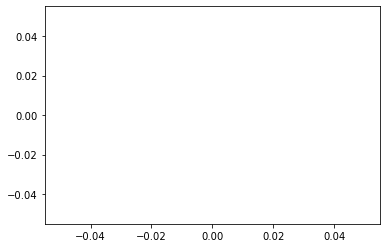

In [46]:
plt.plot(data)

In [ ]:
data2 = dataset.values

In [49]:
plt.plot(data2[timestamps,0])

NameError: name 'timestamps' is not defined

In [52]:
for i in range(30,40):
    plt.figure()
    for t in timestamps:
        plt.plot(data2[t,i])

NameError: name 'timestamps' is not defined

In [55]:
c = dataset.corr().abs()

In [57]:
for i in range(0,c.shape[0]):
    c[i][i] = 0

In [59]:
s = c.unstack()

In [61]:
s

0    0      0.000000
     1      0.750833
     2      0.528709
     3      0.598725
     4      0.804868
              ...   
861  857    0.939356
     858    0.702612
     859    0.729298
     860    0.814232
     861    0.000000
Length: 743044, dtype: float64

In [63]:
so = s.sort_values(kind="quicksort")

In [64]:
so

0    0      0.000000
294  294    0.000000
293  293    0.000000
292  292    0.000000
291  291    0.000000
              ...   
769  770    0.990573
801  588    0.992175
588  801    0.992175
663  39     0.993220
39   663    0.993220
Length: 743044, dtype: float64

In [65]:
type(so)

pandas.core.series.Series

In [66]:
np.where(c[0] > 0.95)

(array([ 61, 147, 241], dtype=int64),)